# Housing Price prediction Part 2b - Advanced feature engineering
## Goal:
1. This module produce a better engineered dataset for better model performance
2. Student should implement this module at home to understand the logic

In [1]:
# Data wrangling and exploration
import pandas as pd
import numpy as np 
import scipy.stats
from scipy import stats
from scipy.stats import spearmanr
from feature_engine.creation import MathFeatures
import statsmodels.api as sm

# System
import os
import time
import warnings
from tqdm.notebook import tqdm

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# SKlearn
from sklearn.preprocessing import MinMaxScaler,  OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

ModuleNotFoundError: No module named 'pandas'

In [15]:
# Visualisation Style Configuration 
palette = ['#009688', '#ff5722','#795548','#3f51b5','#673ab7','#2196f3','#8bc34a','#9e9e9e', '#8ac52a', '#643e67']
alpha = 0.5
_theme = sns.set_theme(style="whitegrid", font="sans-serif",palette=palette[0:2], font_scale=0.100, rc={'grid.color': '#d4d5d6', 'grid.linewidth': 0.25})
_fig = plt.figure(figsize=(15,7))
_context = sns.set_context('paper', font_scale=1.4)
sns.set(rc={"figure.dpi":75, 'savefig.dpi':75})


<Figure size 1500x700 with 0 Axes>

In [5]:
# load data into pandas dataframe for train and test data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
df = pd.concat([train, test], axis=0, sort=False)

In [7]:
# explore dataset 

def EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    print(f"Number of Samples: {size[0]:10}\nNumber of Features: {size[1]:2}\nDuplicated Entries: {sum_duplicates:1}\nNull Entries: {sum_null:10}\nTotal Null Entries: {count_NaN_rows[0]:3} ({((count_NaN_rows[0] / df.shape[0])*100):.1f}%)\n")
    
    # top 5 missing
    print(f"{'Top 10 with missing':.^30}")
    missing_df = df.isna().sum() / df.shape[0]
    print(f'{round(missing_df.sort_values(ascending=False).head(10)*100,1)}')
    
# Null Values Analysis

def null_features(df):
    # prep dataset EDA values
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Uniques'] = df.nunique().values
    summary['Null'] = df.isna().sum().values
    summary['Null(%)'] = round((summary['Null']  / len(df)*100),1).astype(str)+'%'

    # prep df
    summary = summary.sort_values(by=['Null', 'Name'], ascending=[False, True])
    summary.index = range(1, len(summary)+1)
    summary.drop(index=summary[summary['Null']==0].index, inplace=True)
    
    # return summary
    return summary

# Show datasets
print(f"\n{'Train Dataset':_^30}")
EDA(train)

print(f"\n{'Test Dataset':_^30}")
EDA(test)


________Train Dataset_________
Number of Samples:       1460
Number of Features: 81
Duplicated Entries: 0
Null Entries:       7829
Total Null Entries: 1460 (100.0%)

.....Top 10 with missing......
PoolQC         99.5
MiscFeature    96.3
Alley          93.8
Fence          80.8
MasVnrType     59.7
FireplaceQu    47.3
LotFrontage    17.7
GarageYrBlt     5.5
GarageCond      5.5
GarageType      5.5
dtype: float64

_________Test Dataset_________
Number of Samples:       1459
Number of Features: 80
Duplicated Entries: 0
Null Entries:       7878
Total Null Entries: 1459 (100.0%)

.....Top 10 with missing......
PoolQC          99.8
MiscFeature     96.5
Alley           92.7
Fence           80.1
MasVnrType      61.3
FireplaceQu     50.0
LotFrontage     15.6
GarageYrBlt      5.3
GarageQual       5.3
GarageFinish     5.3
dtype: float64


In [8]:
null_features(df)

,Name,dtypes,Uniques,Null,Null(%)
1,PoolQC,object,3,2909,99.7%
2,MiscFeature,object,4,2814,96.4%
3,Alley,object,2,2721,93.2%
4,Fence,object,4,2348,80.4%
5,MasVnrType,object,3,1766,60.5%
6,SalePrice,float64,663,1459,50.0%
7,FireplaceQu,object,5,1420,48.6%
8,LotFrontage,float64,128,486,16.6%
9,GarageCond,object,5,159,5.4%
10,GarageFinish,object,3,159,5.4%


In [10]:
# Use KNNImputer to impute missing values in LotFrontage
def LotFrontage_KNN_Imputer(data, n_neighbors=5):
    df_KNN_imp = data[['Neighborhood', 'LotFrontage', 'LotArea']].copy()

    df_KNN_imp = pd.get_dummies(df_KNN_imp, columns=['Neighborhood'], drop_first=False)

    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_KNN_imp['LotFrontage'] = imputer.fit_transform(df_KNN_imp)

    # Merge imputed values back into the original data
    data['LotFrontage'] = df_KNN_imp['LotFrontage']
    
    return data

# Example usage
df = LotFrontage_KNN_Imputer(df)
train = LotFrontage_KNN_Imputer(train)
test = LotFrontage_KNN_Imputer(test)

In [11]:
# replace missing values in the following features with 'None' 
none_features = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]

df = df.fillna({col: 'None' for col in none_features})
train = train.fillna({col: 'None' for col in none_features})
test = test.fillna({col: 'None' for col in none_features})

In [12]:
# Ensure there are no Garage details if GarageYrBlt is missing
df.loc[df['GarageYrBlt'].isna(), ['GarageType', 'GarageCond', 'GarageFinish', 'GarageQual']] = 'None'
train.loc[train['GarageYrBlt'].isna(), ['GarageType', 'GarageCond', 'GarageFinish', 'GarageQual']] = 'None'
test.loc[test['GarageYrBlt'].isna(), ['GarageType', 'GarageCond', 'GarageFinish', 'GarageQual']] = 'None'

In [13]:
# Impute missing values in all other features
def impute_numerical(data, strategy='constant', fill_value=0):
    imputer = SimpleImputer(strategy=strategy)
    imputer.fit(data)
    return imputer

def impute_categorical(data, strategy='most_frequent'):
    imputer = SimpleImputer(strategy=strategy)
    imputer.fit(data)
    return imputer

null = null_features(df.drop(columns=['SalePrice']))

# Impute numerical columns
num_cols = null[null['dtypes'] == 'float64']['Name'].tolist()
num_imputer = impute_numerical(train[num_cols])
train[num_cols] = num_imputer.transform(train[num_cols])
test[num_cols] = num_imputer.transform(test[num_cols])
df[num_cols] = num_imputer.transform(df[num_cols])

# Impute categorical columns
cat_cols = null[null['dtypes'] != 'float64']['Name'].tolist()
cat_imputer = impute_categorical(train[cat_cols])
train[cat_cols] = cat_imputer.transform(train[cat_cols])
test[cat_cols] = cat_imputer.transform(test[cat_cols])
df[cat_cols] = cat_imputer.transform(df[cat_cols])

/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<Figure size 480x360 with 0 Axes>

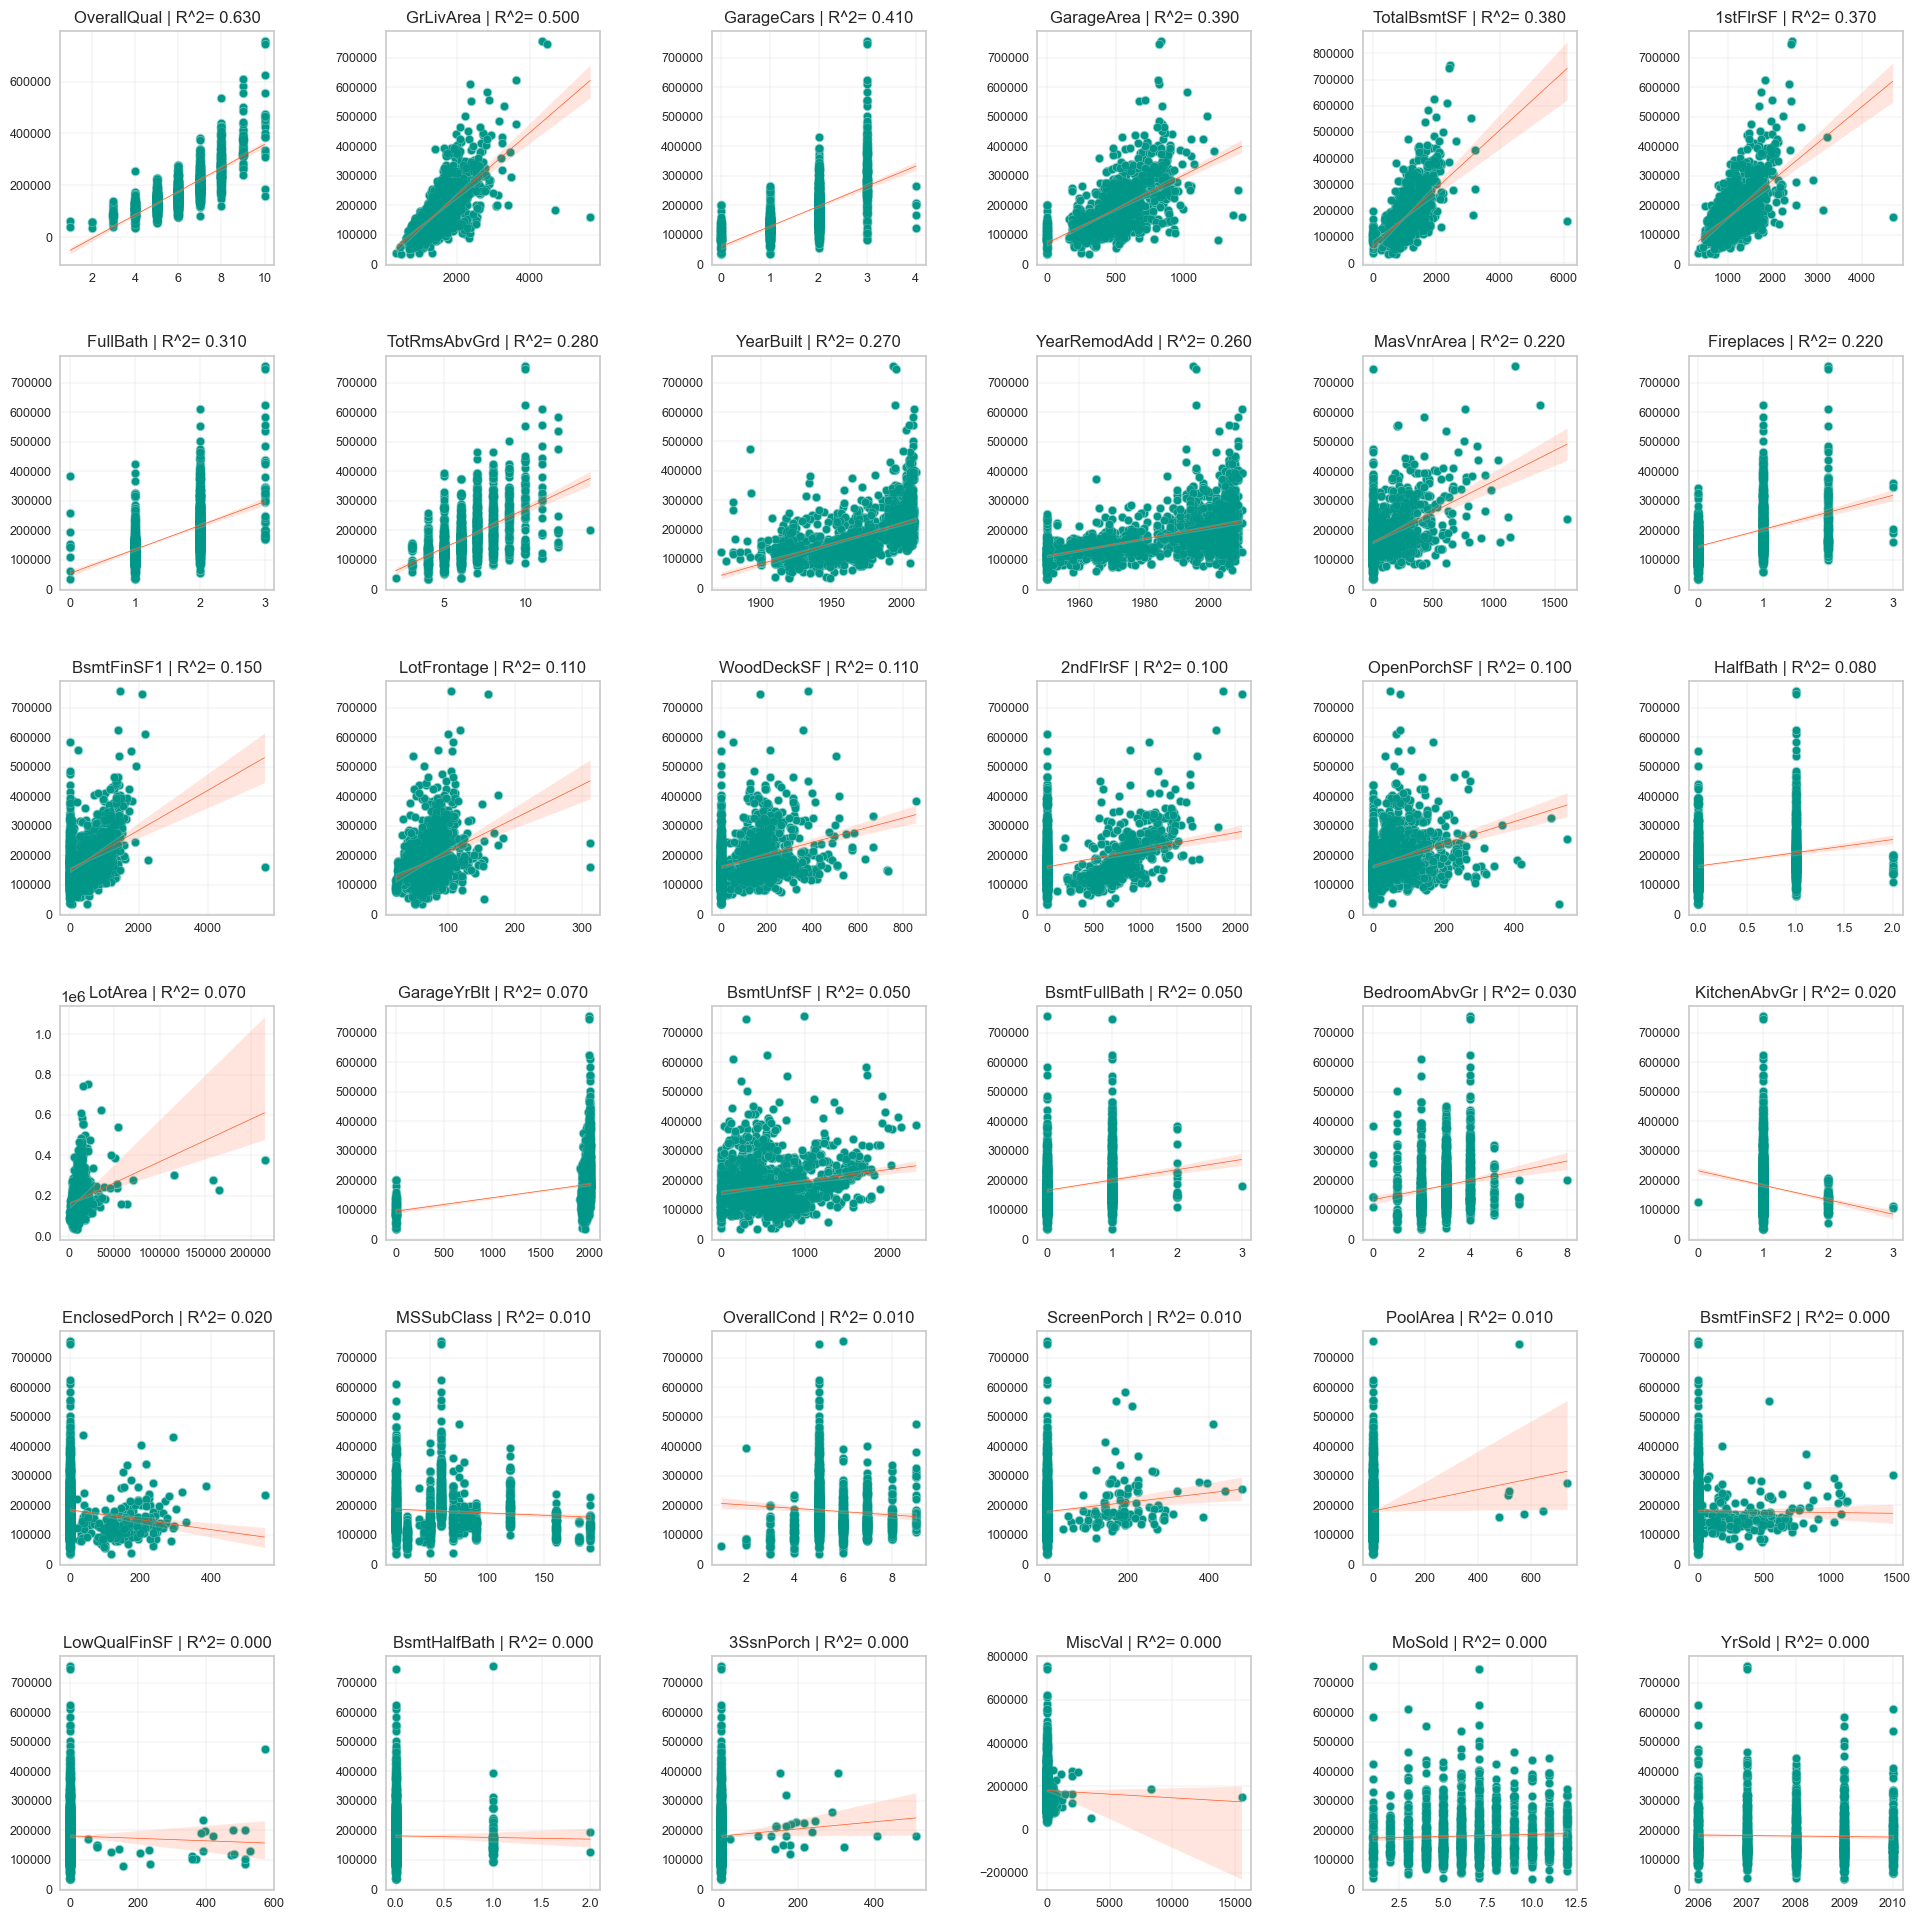

In [16]:
# plot all features in test set with scatterplot
def scatterplot_target(df,row,col,h,w): 
    i = 0
    temp = df.select_dtypes(include=[np.number]).drop(['Id'], axis=1)
    features = df.select_dtypes(include=[np.number]).drop(['Id','SalePrice'], axis=1).columns
    

    r2 = [{'Feature': feature, 'R^2': np.NaN} for feature in features]

    for i, feature in enumerate(features):
        corr, _ = scipy.stats.pearsonr(temp[feature].loc[temp[feature].notna()], df['SalePrice'].loc[temp[feature].notna()])
        r2[i]['R^2'] = round(corr**2,2)
        
    r2_sorted = sorted(r2, key=lambda x: x['R^2'], reverse=True)
    features = [d['Feature'] for d in r2_sorted]
    
    i = 0    
    # set theme
    sns.set_theme(style="whitegrid", palette=palette[0:1], rc={'grid.color': '#d4d5d6', 'grid.linewidth': 0.25})
    plt.figure()
    fig, ax = plt.subplots(row,col,figsize=(h,w), dpi=100)

    for feature in features:
        i += 1
        corr, _ = scipy.stats.pearsonr(temp[feature].loc[temp[feature].notna()], df['SalePrice'].loc[temp[feature].notna()])
        r2 = round(corr**2,2)
        plt.subplot(row,col,i)
        sns.scatterplot(data = temp, x = feature, y='SalePrice')
        
        sns.regplot(data=temp, x=feature, y='SalePrice', 
                    scatter_kws={"color": palette[0], 'alpha': alpha*0.5}, 
                    line_kws={"color": palette[1], "linewidth": 0.5})
        
        # add R^2 score to labels 
        subheader = "{} | R^2= {:.3f}".format(feature, r2)
        plt.title(subheader, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=9, pad = 0)
        plt.tick_params(axis='y', which='major', labelsize=9, pad = 0)
        plt.ylabel("",fontsize=0)
        plt.xlabel("",fontsize=0)
    fig.tight_layout(pad=3.0)
    plt.show()
    
scatterplot_target(train,6,6,20,20)

In [17]:
# convert MSSubClass to categorical
df['MSSubClass'] = 'SC'+df['MSSubClass'].astype(str)
train['MSSubClass'] = 'SC'+train['MSSubClass'].astype(str)
test['MSSubClass'] = 'SC'+test['MSSubClass'].astype(str)

In [18]:
# Calculate the median of GrLivArea per bedroom for non-zero BedroomAbvGr values based on the Median of GrLivArea per bedroom for non-zero BedroomAbvGr values in the training set
def update_zero_bedrooms(dataframe):
    # Calculate the median of GrLivArea per bedroom for non-zero BedroomAbvGr values
    median_GrLivArea_per_bedroom = train[train['BedroomAbvGr'] != 0].groupby('BedroomAbvGr')['GrLivArea'].median()

    # Select the rows with BedroomAbvGr equal to 0
    rows_with_zero_bedrooms = dataframe[dataframe['BedroomAbvGr'] == 0][['BedroomAbvGr', 'GrLivArea']]

    # Find the closest BedroomAbvGr value based on GrLivArea for each row with zero bedrooms
    for index, row in rows_with_zero_bedrooms.iterrows():
        closest_bedroom = median_GrLivArea_per_bedroom.index[np.abs(median_GrLivArea_per_bedroom - row['GrLivArea']).argmin()]
        dataframe.loc[index, 'BedroomAbvGr'] = closest_bedroom
        
# Apply the function to the training and test sets
update_zero_bedrooms(df)
update_zero_bedrooms(train)
update_zero_bedrooms(test)

### Feature Grouping

/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


BsmtExposure
Gd      226975.0
Av      185850.0
Mn      182450.0
No      154000.0
None    104025.0
Name: SalePrice, dtype: float64

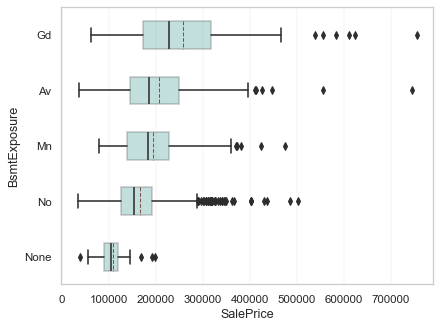

In [19]:
# BsmtExposure 
sns.boxplot(x='SalePrice', y='BsmtExposure', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order=['Gd', 'Av', 'Mn', 'No', 'None']) 


(df.groupby(['BsmtExposure']).count()['Id'] / len(df)).sort_values(ascending=False)
df.groupby(['BsmtExposure'])['SalePrice'].median().sort_values(ascending=False)


In [20]:
# map 'Av', 'Mn' in BsmtExposure to Av
df['BsmtExposure'] = df['BsmtExposure'].replace(['Av', 'Mn'], 'Av')
train['BsmtExposure'] = train['BsmtExposure'].replace(['Av', 'Mn'], 'Av')
test['BsmtExposure'] = test['BsmtExposure'].replace(['Av', 'Mn'], 'Av')

/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


BsmtFinType1
Unf     0.291538
GLQ     0.290853
ALQ     0.146968
Rec     0.098664
BLQ     0.092155
LwQ     0.052758
None    0.027064
Name: Id, dtype: float64

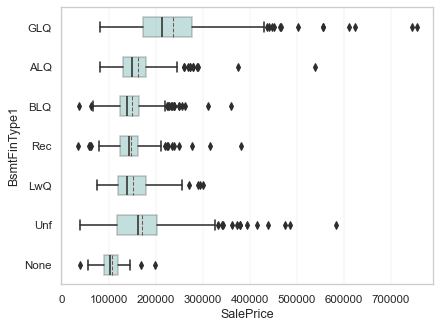

In [21]:
# BsmtFinType1 
sns.boxplot(x='SalePrice', y='BsmtFinType1', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order= ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'None']) 


(df.groupby(['BsmtFinType1']).count()['Id'] / len(df)).sort_values(ascending=False)

# df.groupby(['BsmtFinType1'])['SalePrice'].median().sort_values(ascending=False)

/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


,Id,Median
BsmtFinType2,,
Unf,2493,167000.0
Rec,105,148750.0
LwQ,87,154000.0
None,80,104025.0
BLQ,68,143000.0
ALQ,52,174900.0
GLQ,34,203125.0


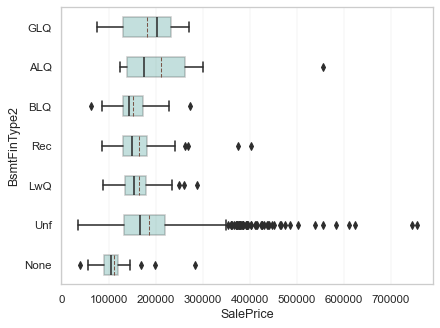

In [22]:
# BsmtFinType2 
sns.boxplot(x='SalePrice', y='BsmtFinType2', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order= ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'None']) 


temp = pd.DataFrame((df.groupby(['BsmtFinType2']).count()['Id']))

temp['Median'] = df.groupby(['BsmtFinType2'])['SalePrice'].median()

temp.sort_values(by='Id', ascending=False)

In [23]:
# map 'ALQ', 'BLQ', 'Rec', 'LwQ' in BsmtFinType1 to Av
df['BsmtFinType1'] = df['BsmtFinType1'].replace(['ALQ', 'BLQ', 'Rec', 'LwQ'], 'Av')
train['BsmtFinType1'] = train['BsmtFinType1'].replace(['ALQ', 'BLQ', 'Rec', 'LwQ'], 'Av')
test['BsmtFinType1'] = test['BsmtFinType1'].replace(['ALQ', 'BLQ', 'Rec', 'LwQ'], 'Av')

# map 'ALQ', 'BLQ', 'Rec', 'LwQ' in BsmtFinType2 to Av
df['BsmtFinType2'] = df['BsmtFinType2'].replace(['ALQ', 'BLQ', 'Rec', 'LwQ'], 'Av')
train['BsmtFinType2'] = train['BsmtFinType2'].replace(['ALQ', 'BLQ', 'Rec', 'LwQ'], 'Av')
test['BsmtFinType2'] = test['BsmtFinType2'].replace(['ALQ', 'BLQ', 'Rec', 'LwQ'], 'Av')

# map 'MnPrv', 'GdWo', 'MnWw' in Fence to AvPrv
df['Fence'] = df['Fence'].replace(['MnPrv', 'GdWo', 'MnWw'], 'AvPrv')
train['Fence'] = train['Fence'].replace(['MnPrv', 'GdWo', 'MnWw'], 'AvPrv')
test['Fence'] = test['Fence'].replace(['MnPrv', 'GdWo', 'MnWw'], 'AvPrv') 


In [25]:
# map 'CulDSac', 'FR3' in LotConfig to 1 else to 0
df['LotConfig'] = df['LotConfig'].map({'Inside': 0, 'Corner': 0, 'CulDSac': 1, 'FR2': 0, 'FR3': 1})
train['LotConfig'] = train['LotConfig'].map({'Inside': 0, 'Corner': 0, 'CulDSac': 1, 'FR2': 0, 'FR3': 1})
test['LotConfig'] = test['LotConfig'].map({'Inside': 0, 'Corner': 0, 'CulDSac': 1, 'FR2': 0, 'FR3': 1})

In [26]:
# map 'Gtl' in LotSlop to 1 else to 0 
df['LandSlope'] = df['LandSlope'].map({'Gtl': 1, 'Mod': 0, 'Sev': 0})
train['LandSlope'] = train['LandSlope'].map({'Gtl': 1, 'Mod': 0, 'Sev': 0})
test['LandSlope'] = test['LandSlope'].map({'Gtl': 1, 'Mod': 0, 'Sev': 0})

In [27]:
# map '1Story', '1.5Fin', '1.5Unf' in HouseStyle to 2; '2Story', '2.5Fin', '2.5Unf' to 3; 'SFoyer', 'SLvl' to 1
df['HouseStyle'] = df['HouseStyle'].map({'1Story': 2, '1.5Fin': 2, '1.5Unf': 2, '2Story': 3, '2.5Fin': 3, '2.5Unf': 3, 'SFoyer': 1, 'SLvl': 1})
train['HouseStyle'] = train['HouseStyle'].map({'1Story': 2, '1.5Fin': 2, '1.5Unf': 2, '2Story': 3, '2.5Fin': 3, '2.5Unf': 3, 'SFoyer': 1, 'SLvl': 1})
test['HouseStyle'] = test['HouseStyle'].map({'1Story': 2, '1.5Fin': 2, '1.5Unf': 2, '2Story': 3, '2.5Fin': 3, '2.5Unf': 3, 'SFoyer': 1, 'SLvl': 1})

In [28]:
# map 'BrkCmn', 'None' in MasVnrType to 'Other'
df['MasVnrType'] = df['MasVnrType'].replace(['BrkCmn', 'None'], 'Other')
train['MasVnrType'] = train['MasVnrType'].replace(['BrkCmn', 'None'], 'Other')
test['MasVnrType'] = test['MasVnrType'].replace(['BrkCmn', 'None'], 'Other')

In [29]:
# map 'Attchd', 'BuiltIn' in GarageType to its own category else to other category
df['GarageType'] = df['GarageType'].apply(lambda x: x if x in ['Attchd', 'BuiltIn'] else 'Other')
train['GarageType'] = train['GarageType'].apply(lambda x: x if x in ['Attchd', 'BuiltIn'] else 'Other')
test['GarageType'] = test['GarageType'].apply(lambda x: x if x in ['Attchd', 'BuiltIn'] else 'Other')

In [30]:
# map 'Y' in PavedDrive to 1 else to 0
df['PavedDrive'] = df['PavedDrive'].map({'Y': 1, 'P': 0, 'N': 0})
train['PavedDrive'] = train['PavedDrive'].map({'Y': 1, 'P': 0, 'N': 0})
test['PavedDrive'] = test['PavedDrive'].map({'Y': 1, 'P': 0, 'N': 0})

In [31]:
# function to convert nominal to ordinal
def apply_ordinal_encoding(df, features, mapping):
    for feature in features:
        df[feature] = df[feature].map(mapping)
    return df


# convert nominal to ordinal Quality and Condition features
QC_features_full = ['ExterQual', 'ExterCond', 'KitchenQual', 'HeatingQC']
Qual_rate_dict = {
    'Po': 0,  # Poor
    'Fa': 1,  # Fair
    'TA': 1,  # Average/Typical
    'Gd': 2,  # Good
    'Ex': 3   # Excellent
}

df = apply_ordinal_encoding(df, QC_features_full, Qual_rate_dict)
train = apply_ordinal_encoding(train, QC_features_full, Qual_rate_dict)
test = apply_ordinal_encoding(test, QC_features_full, Qual_rate_dict)



# convert nominal to ordinal Quality and Condition for features with missing values
QC_features = ['PoolQC','FireplaceQu','GarageCond','GarageQual','BsmtCond','BsmtQual']
QC_rate_dict = {
    'None':0, # 'None
    'Po': 0,  # Poor
    'Fa': 1,  # Fair
    'TA': 1,  # Average/Typical
    'Gd': 2,  # Good
    'Ex': 3   # Excellent
}

df = apply_ordinal_encoding(df, QC_features, QC_rate_dict)
train = apply_ordinal_encoding(train, QC_features, QC_rate_dict)
test = apply_ordinal_encoding(test, QC_features, QC_rate_dict)


# convert nominal to ordinal BsmtExposure and BsmtFinType features
BsmtExp_features = ['BsmtExposure']
BsmtExposure_dict = {
    'None':0, # No Exposure
    'No':1, # No Basement
    'Av':2, # Average Exposure
    'Gd':3} # Good Exposure   

df = apply_ordinal_encoding(df, BsmtExp_features, BsmtExposure_dict)
train = apply_ordinal_encoding(train, BsmtExp_features, BsmtExposure_dict)
test = apply_ordinal_encoding(test, BsmtExp_features, BsmtExposure_dict)



# convert nominal to ordinal BsmtFinType features
BsmtFin_features = ['BsmtFinType1','BsmtFinType2']
BsmtFinType_dict = {
    'None':0, # No Basement
    'Unf':1, # Unfinshed
    'Av':2, # Grouped Average Exposure
    'GLQ':3} # Good Living Quarters

df = apply_ordinal_encoding(df, BsmtFin_features, BsmtFinType_dict)
train = apply_ordinal_encoding(train, BsmtFin_features, BsmtFinType_dict)
test = apply_ordinal_encoding(test, BsmtFin_features, BsmtFinType_dict)



# convert nominal to ordinal CentralAir feature
YesNo_features = ['CentralAir']
YesNo_dict = {
    'N':0, #  No
    'Y':1 #  Yes
}

df = apply_ordinal_encoding(df, YesNo_features, YesNo_dict)
train = apply_ordinal_encoding(train, YesNo_features, YesNo_dict)
test = apply_ordinal_encoding(test, YesNo_features, YesNo_dict)


# convert nominal to ordinal GarageFinish
GarageFinish_features = ['GarageFinish']
GarageFinish_dict = {
    'None':0, # No Garage
    'Unf':1, # Unfinished
    'RFn':2, # Rough Finished
    'Fin':3} # Finished
    
df = apply_ordinal_encoding(df, GarageFinish_features, GarageFinish_dict)
train = apply_ordinal_encoding(train, GarageFinish_features, GarageFinish_dict)
test = apply_ordinal_encoding(test, GarageFinish_features, GarageFinish_dict)
 
 
# convert nominal to ordinal Fence feature
fence_features = ['Fence']
fence_dict = {
    'None':0, # No Fence
    'AvPrv':1, # Average Privacy
    'GdPrv':2} # Good Privacy
    
df = apply_ordinal_encoding(df, fence_features, fence_dict)
train = apply_ordinal_encoding(train, fence_features, fence_dict)
test = apply_ordinal_encoding(test, fence_features, fence_dict)

### Feature Engineering and Selection
Feature engineering is an essential step in building machine learning models, as it can significantly improve model performance by creating new features or transforming existing ones. In this section, we'll explore different steps for feature engineering and selection in the dataset. The goal of this section is to create a dataset that is ready for training our machine learning models.

In [32]:
# remove outliers GrLivArea > 4000
df = df.drop(df[(df['GrLivArea']>4000)].index)
train = train.drop(train[(train['GrLivArea']>4000)].index)

In [33]:
# create new feature for total area and drop old features
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

In [34]:
# create new feature for total bathrooms and drop old features 
df['TotalBath'] = df['FullBath'] + df['HalfBath']*0.5 + df['BsmtFullBath'] + df['BsmtHalfBath']*0.5
train['TotalBath'] = train['FullBath'] + train['HalfBath']*0.5 + train['BsmtFullBath'] + train['BsmtHalfBath']*0.5
test['TotalBath'] = test['FullBath'] + test['HalfBath']*0.5 + test['BsmtFullBath'] + test['BsmtHalfBath']*0.5

In [35]:
# create new feature for YearRemodAgg houses and drop old features 
df['YearRemodAgg'] = df[['YearRemodAdd', 'YearBuilt']].max(axis=1)
train['YearRemodAgg'] = train[['YearRemodAdd', 'YearBuilt']].max(axis=1)
test['YearRemodAgg'] = test[['YearRemodAdd', 'YearBuilt']].max(axis=1)

In [36]:
# create new feature for total porch area and drop old features
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
train['TotalPorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']
test['TotalPorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch']

In [37]:
# is a new building
df['IsNew'] = df['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)
test['IsNew'] = test['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

In [38]:
# LotArea condition
df['AreaCondition'] = df['LotArea'] * df['OverallCond']
train['AreaCondition'] = train['LotArea'] * train['OverallCond']
test['AreaCondition'] = test['LotArea'] * test['OverallCond']

# totalSF condition 
df['TotalSFCondition'] = df['TotalSF'] * df['OverallCond']
train['TotalSFCondition'] = train['TotalSF'] * train['OverallCond']
test['TotalSFCondition'] = test['TotalSF'] * test['OverallCond']

# GarageArea condition
df['GarageAreaCondition'] = df['GarageArea'] * df['GarageCond']
train['GarageAreaCondition'] = train['GarageArea'] * train['GarageCond']
test['GarageAreaCondition'] = test['GarageArea'] * test['GarageCond']

# TotalBsmntSF condition
df['TotalBsmntSFCondition'] = df['TotalBsmtSF'] * df['BsmtCond']
train['TotalBsmntSFCondition'] = train['TotalBsmtSF'] * train['BsmtCond']
test['TotalBsmntSFCondition'] = test['TotalBsmtSF'] * test['BsmtCond']

In [39]:
# LotArea quality 
df['AreaQuality'] = df['LotArea'] * df['OverallQual']
train['AreaQuality'] = train['LotArea'] * train['OverallQual']
test['AreaQuality'] = test['LotArea'] * test['OverallQual']

# totalSF quality
df['TotalSFQuality'] = df['TotalSF'] * df['OverallQual']
train['TotalSFQuality'] = train['TotalSF'] * train['OverallQual']
test['TotalSFQuality'] = test['TotalSF'] * test['OverallQual']
 
# GarageArea quality
df['GarageAreaQuality'] = df['GarageArea'] * df['GarageQual']
train['GarageAreaQuality'] = train['GarageArea'] * train['GarageQual']
test['GarageAreaQuality'] = test['GarageArea'] * test['GarageQual']

# TotalBsmntSF quality
df['TotalBsmntSFQuality'] = df['TotalBsmtSF'] * df['BsmtQual']
train['TotalBsmntSFQuality'] = train['TotalBsmtSF'] * train['BsmtQual']
test['TotalBsmntSFQuality'] = test['TotalBsmtSF'] * test['BsmtQual']

In [40]:
# are per bedroom 
df['AreaPerBedroom'] = df['GrLivArea'] / df['BedroomAbvGr']
train['AreaPerBedroom'] = train['GrLivArea'] / train['BedroomAbvGr']
test['AreaPerBedroom'] = test['GrLivArea'] / test['BedroomAbvGr']

# totalSF per bedroom
df['TotalSFPerBedroom'] = df['TotalSF'] / df['BedroomAbvGr']
train['TotalSFPerBedroom'] = train['TotalSF'] / train['BedroomAbvGr']
test['TotalSFPerBedroom'] = test['TotalSF'] / test['BedroomAbvGr']

In [41]:
# normalise skewed features
temp = train.copy()
for col in temp.select_dtypes(include=[np.number]).columns:
    temp[col] = np.log1p(temp[col])
after = temp.select_dtypes(include=[np.number]).drop(['Id'], axis=1).corr()['SalePrice'].sort_values(ascending=False)    
before = train.select_dtypes(include=[np.number]).drop(['Id'], axis=1).corr()['SalePrice'].sort_values(ascending=False)
((after - before)).sort_values(ascending=False)[:10]

AreaQuality      0.213686
AreaCondition    0.131001
OpenPorchSF      0.130563
LotArea          0.130271
TotalPorchSF     0.104008
GarageCond       0.100059
CentralAir       0.095652
GarageQual       0.087034
OverallCond      0.078445
BsmtFinType2     0.074854
Name: SalePrice, dtype: float64

/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_53911/1264186612.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde = True, hist=True, fit = stats.norm, ax = ax[0, 1])
/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version.

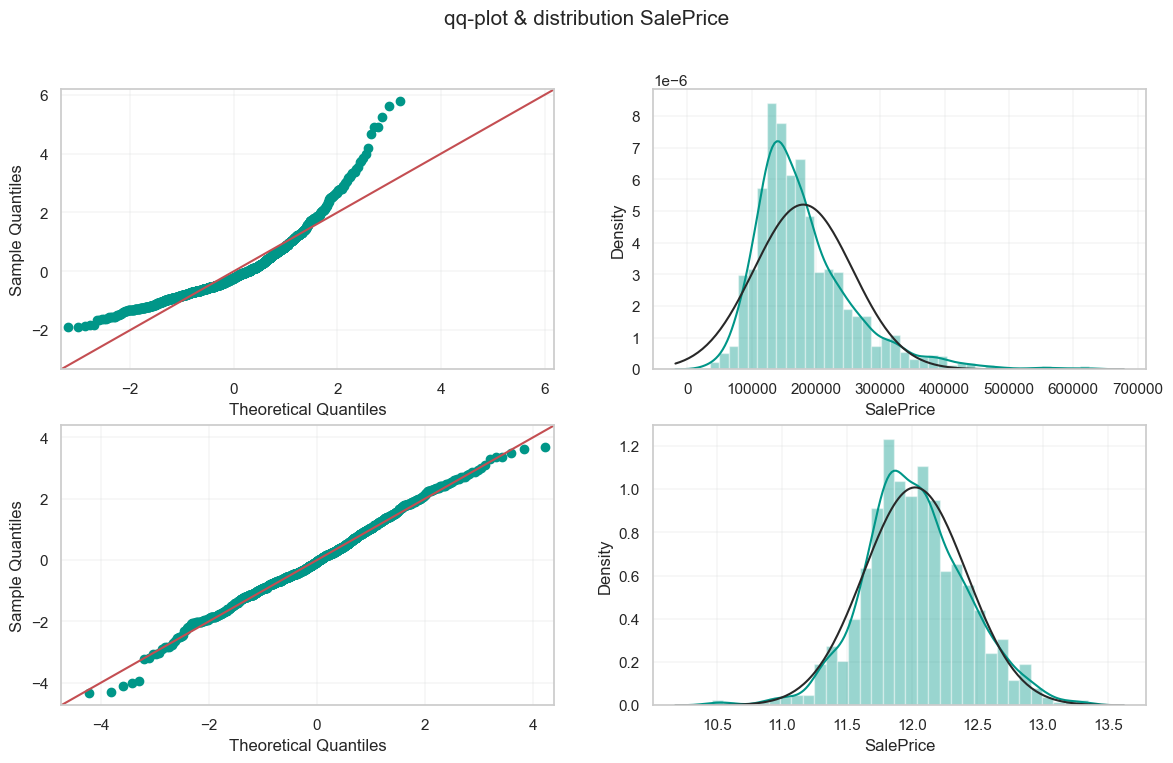

In [42]:
# plot the distribution of SalePrice before and after normalisation
def sekewness(df, col):
    fig, ax = plt.subplots(2,2, figsize= (14,8), dpi = 100)
    fig.suptitle(f"qq-plot & distribution {col}", fontsize= 15)
    sm.qqplot(df[col], stats.t, distargs=(4,),fit=True, line="45", ax = ax[0,0])
    sns.distplot(df[col], kde = True, hist=True, fit = stats.norm, ax = ax[0, 1])


    sm.qqplot(np.log1p(df[col]), stats.t, distargs=(4,),fit=True, line="45", ax = ax[1,0])
    sns.distplot(np.log1p(df[col]), kde = True, hist=True, fit = stats.norm, ax = ax[1, 1])
    plt.show()

sekewness(train, 'SalePrice')

In [43]:
# apply log transform to skewed features
logNorm = ['GrLivArea',  'SalePrice', 'LotArea',  'AreaCondition', 'AreaQuality','LotFrontage','TotalPorchSF'] #['1stFlrSF', 'GrLivArea',  'SalePrice', 'LotArea',  'AreaCondition', 'TotalSF', 'AreaQuality','TotalSFQuality' , 'TotalBsmtSF','LotFrontage', 'LotArea','TotalPorchSF']
for col in logNorm:
    if col != 'SalePrice':
        train[col] = np.log1p(train[col])
        df[col] = np.log1p(df[col])
        test[col] = np.log1p(test[col])
    else:
        train[col] = np.log1p(train[col])
        df[col] = np.log1p(df[col])

In [44]:
# Normalize numerical features min max scaler 
scaler = MinMaxScaler()

# fit and transform train data
train_drop = logNorm.append('Id')
train[train.drop(['Id', 'SalePrice'], axis=1).select_dtypes(include=[np.number]).columns] = scaler.fit_transform(train[train.drop(['Id', 'SalePrice'], axis=1).select_dtypes(include=[np.number]).columns])

# transform test data
test_drop =  logNorm.remove('SalePrice')
test[test.drop(['Id'], axis=1).select_dtypes(include=[np.number]).columns] = scaler.transform(test[test.drop(['Id'], axis=1).select_dtypes(include=[np.number]).columns])

In [45]:
# reduce the cardinality of categorical features by grouping rare categories into 'Other'
def group_rare_categories(train, test, threshold=0.025):
    for col in train.select_dtypes('object').columns:
        value_counts = train[col].value_counts(normalize=True)

        mask = value_counts < threshold
        rare_categories = value_counts[mask].index.tolist()

        train[col] = train[col].apply(lambda x: 'Other' if x in rare_categories else x)
        
        # Replace categories in test set that are not present in train set with 'Other'
        test[col] = test[col].apply(lambda x: 'Other' if x not in train[col].unique() or x in rare_categories else x)

    return (train, test)

train, test = group_rare_categories(train, test)

In [46]:
# one hot encoding for categorical features
def one_hot_encode(df, cols):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_df = pd.DataFrame(ohe.fit_transform(df[cols]), columns=ohe.get_feature_names_out(cols))
    ohe_df.index = df.index  
    df = pd.concat([df, ohe_df], axis=1)
    df.drop(cols, axis=1, inplace=True)
    return df

train = one_hot_encode(train, train.select_dtypes('object').columns)
test = one_hot_encode(test, test.select_dtypes('object').columns)

/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/yuan/opt/anaconda3/envs/ox/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [47]:
train.head()

,Id,LotFrontage,LotArea,LotConfig,LandSlope,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,MiscFeature_Other,MiscFeature_Shed,SaleType_COD,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial
0,1,0.413268,0.366271,0.0,1.0,1.0,0.666667,0.500,0.949275,0.883333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2,0.490307,0.391245,0.0,1.0,0.5,0.555556,0.875,0.753623,0.433333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3,0.429990,0.422289,0.0,1.0,1.0,0.666667,0.500,0.934783,0.866667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,4,0.383633,0.390223,0.0,1.0,1.0,0.666667,0.500,0.311594,0.333333,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,5,0.508439,0.468694,0.0,1.0,1.0,0.777778,0.500,0.927536,0.833333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [48]:
train.to_csv("./data/train_clean_advanced.csv", index = False)
test.to_csv("./data/test_clean_advanced.csv", index = False)